In [1]:
from scipy.cluster.vq import kmeans, vq, kmeans2, whiten
from numpy import array, reshape, zeros
from python_speech_features import mfcc, delta, logfbank
from scipy.spatial import distance
from scipy.spatial.distance import pdist
import scipy.io.wavfile as wav
import wave
import matplotlib.pyplot as plt
import numpy as np
import math
import IPython.display as ipd
SIZE = 1

先確認是否能夠讀入語音檔

In [2]:
ipd.Audio('對話內容.wav')
ipd.Audio('註冊語者01.wav')

使用python_speech_features來計算mfcc和delta、double-delta

In [3]:
(rate,sig) = wav.read("註冊語者01.wav")
mfcc_feat = mfcc(sig,rate)
d_mfcc_feat = delta(mfcc_feat, 2)
d2_mfcc_feat = delta(d_mfcc_feat, 2)

測試看看結果，證實正確，最後將這些數值合併成39個特徵值的矩陣

In [4]:
print(d2_mfcc_feat.shape)
print(d_mfcc_feat.shape)
#combine_feat = np.append(np.append(mfcc_feat, d_mfcc_feat, axis=1), d2_mfcc_feat, axis=1)
combine_feat = np.concatenate((mfcc_feat,d_mfcc_feat,d2_mfcc_feat), axis=1)
code_books = []
print(combine_feat.shape)

(999, 13)
(999, 13)
(999, 39)


對此矩陣進行vector quantization，在此假設code book size為512
其他speaker的語音檔也如法炮製，並將結果存於code_books中，應該是一個4個元素的list

In [5]:
codebook, labeled_obs = kmeans2(data=combine_feat, k=SIZE)
print(codebook.shape)
code_books.append(codebook)

for speaker in '234':
    (rate,sig) = wav.read("註冊語者0" + speaker + ".wav")
    mfcc_feat = mfcc(sig,rate)
    d_mfcc_feat = delta(mfcc_feat, 2)
    d2_mfcc_feat = delta(d_mfcc_feat, 2)
    combine_feat = np.concatenate((mfcc_feat,d_mfcc_feat,d2_mfcc_feat), axis=1)
    #combine_feat = np.append(np.append(mfcc_feat, d_mfcc_feat, axis=1), d2_mfcc_feat, axis=1)
    codebook, labeled_obs = kmeans2(data=combine_feat, k=SIZE)
    code_books.append(codebook)

(1, 39)


讀入對話內容語音檔，並且使用歐幾里德距離來計算每個訊號特徵和參考特徵之間的差異，將結果存入result

In [6]:
(rate,sig) = wav.read("對話內容.wav")
mfcc_feat = mfcc(sig,rate)
d_mfcc_feat = delta(mfcc_feat, 2)
d2_mfcc_feat = delta(d_mfcc_feat, 2)
#test_feature_vector = np.append(np.append(mfcc_feat, d_mfcc_feat, axis=1), d2_mfcc_feat, axis=1)
test_feature_vector = np.concatenate((mfcc_feat,d_mfcc_feat,d2_mfcc_feat), axis=1)
test_frame_num = test_feature_vector.shape[0]
print(test_feature_vector)
print(test_frame_num)
result = np.zeros(test_frame_num)
temp_min = np.zeros(4)
for i in range(test_frame_num):
    for j in range(4):
        for k in range(SIZE):
            x = (test_feature_vector[i,:], code_books[j][k, :])
            dist = sum(pdist(x, metric='euclidean'))
            if k == 0:
                temp_min[j] = dist
            else:
                if dist < temp_min[j]:
                    temp_min[j] = dist
    index = np.argmin(temp_min)
    result[i] = index


[[ 1.19105222e+01 -2.52417727e+01 -5.43302469e+00 ... -6.13639459e-01
  -1.75801261e-01 -1.49060403e-01]
 [ 1.19244191e+01 -2.59663304e+01 -5.15507087e+00 ... -6.80254987e-01
  -6.74012803e-02 -1.13553311e-01]
 [ 1.21900290e+01 -2.58000468e+01 -3.20824779e+00 ... -4.69117754e-01
   1.10505278e-02  6.35995757e-02]
 ...
 [ 1.32191087e+01 -2.10063391e+01 -6.40080881e+00 ... -1.04868138e+00
  -6.49677731e-01 -9.55397626e-01]
 [ 1.32610163e+01 -2.20521248e+01 -6.14442969e+00 ... -1.28289640e+00
  -5.54965821e-01 -7.77192881e-01]
 [ 1.30048586e+01 -2.13497785e+01 -3.31983820e+00 ... -6.81378744e-01
  -2.33280776e-01 -2.95840185e-01]]
2094


印出result，雖然可以看出大致趨勢（從區間密集程度），但無法明確辨識，故必須做smoothing

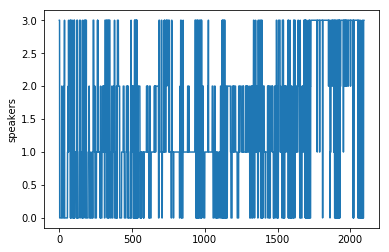

In [7]:
plt.plot(result)
plt.ylabel("speakers")
plt.savefig('output1.png')

實作smoothing

In [8]:
smooth_result = np.zeros(test_frame_num)
smooth_size = 100
overlap = smooth_size//4
for i in range(test_frame_num//smooth_size):
    count = np.zeros(4)
    for j in range(smooth_size):
        if i == 0:
            count[int(result[int(i*smooth_size + j)])] = count[int(result[int(i*smooth_size + j)])] + 1
        else:
            count[int(result[int(i*smooth_size + j - overlap)])] = count[int(result[int(i*smooth_size + j - overlap)])] + 1
    index = np.argmax(count)
    for j in range(smooth_size):
        if i == 0:
            smooth_result[int(i*smooth_size + j)] = index
        else:
            smooth_result[int(i*smooth_size + j - overlap)] = index

再一次印出result，發現這次可以看出四位speaker使用者（分別對應到index0,index1,index2,index3）

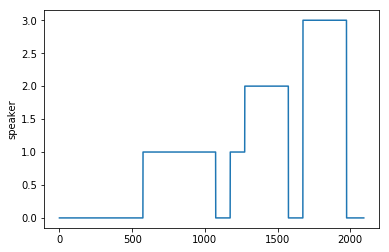

In [9]:
plt.plot(smooth_result)
plt.ylabel("speaker")
plt.savefig('output2.png')

In [10]:
result
file = open('./output','w')
print(result, file=file)